In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import os
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from PIL import Image
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = './object/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("object/training/label_2/annotations_list.pkl")
annotations_list.head()

,img_name,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,rotation_y
0,004863,Car,0.0,0,-1.55,572.44,181.56,611.95,219.71,1.66,1.73,3.05,-0.82,2.08,33.40,-1.57
1,004863,Tram,0.0,0,-1.48,498.85,149.49,551.40,204.32,3.62,2.60,15.21,-6.27,2.16,55.58,-1.60
2,004863,Car,0.0,1,2.12,56.46,195.89,220.78,260.91,1.47,1.71,4.36,-12.68,2.15,19.71,1.55
3,004863,Car,0.0,0,1.92,321.08,188.65,383.52,221.93,1.52,1.71,3.89,-12.88,2.34,36.20,1.58
4,004863,DontCare,-1.0,-1,-10.00,280.40,183.35,291.90,212.56,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00


In [3]:
img_list = list(annotations_list["img_name"].unique())[:10]
train_list, val_list = train_test_split(img_list, test_size=0.1, shuffle=True, random_state=0)
print("train_list has", len(train_list), "images.")
print("val_list has", len(val_list), "images.")

train_list has 9 images.
val_list has 1 images.


# 学習データの作成

In [4]:
IMG_WIDTH = 1280
IMG_HEIGHT = IMG_WIDTH // 16 * 5 #400
MODEL_SCALE = 8

def preprocess_image(img):
    #画像サイズを統一
    img_dummy = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3])
    img_dummy[:img.shape[0], :img.shape[1]] = img
    return (img_dummy / 255).astype('float32')

def get_mask_and_regr(img_name, annotations_list):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['width', 'height']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 2], dtype='float32')
    
    annotations = annotations_list[annotations_list["img_name"]==img_name]
    
    target_type = ['Car', 'Van', 'Truck']
    for _, anno in annotations.iterrows():
        if anno["type"] in target_type:
            # annotationをx, y, width, heightに変換
            x = (anno["left"]+anno["right"])/2 / MODEL_SCALE
            y = (anno["top"]+anno["bottom"])/2 / MODEL_SCALE
            width = anno["right"]-anno["left"] / MODEL_SCALE
            height = anno["bottom"]-anno["top"] / MODEL_SCALE
            x = np.round(x).astype('int')
            y = np.round(y).astype('int')
            
            # x, y, width, heightからmask, regrを作成
            if True:
                mask[y, x] = 1
                regr[y, x, 0] = height
                regr[y, x, 1] = width
    return mask, regr

original image


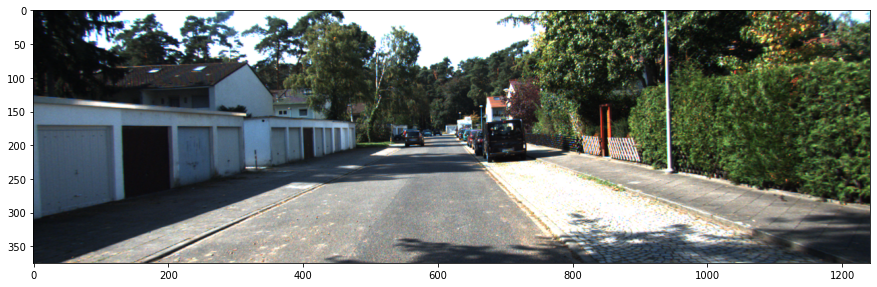

In [5]:
def get_img_path(img_name_list):
    for i in range(len(img_name_list)):
        img_name_list[i] = PATH + "image_2/" + img_name_list[i] + ".png"
        return img_name_list

img_name = train_list[0]
img_name_list = get_img_path([img_name])

print("original image")
img = plt.imread(img_name_list[0])
plt.figure(figsize=(15,8))
plt.imshow(img)

resized image


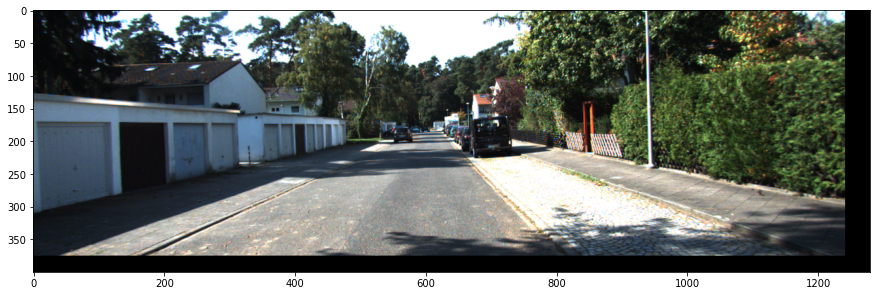

In [6]:
print("resized image")
img = preprocess_image(img)
plt.figure(figsize=(15,8))
plt.imshow(img*255)

vehicle mask


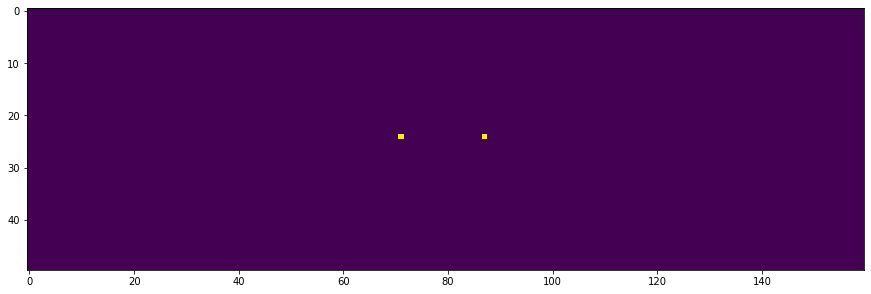

In [7]:
print("vehicle mask")
mask, regr = get_mask_and_regr(img_name, annotations_list)
plt.figure(figsize=(15,8))
plt.imshow(mask)

# 学習データ生成のためのclassを定義

In [8]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, annotation, root_dir, training=True):
        self.data_list = data_list
        self.anno = annotation
        self.root_dir = root_dir
        self.training = training
        
        self.anno = pd.read_pickle(ANNOTATIONS)
        

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data
        img_name = self.data_list[idx]
        img_path = self.root_dir + "image_2/" + img_name + ".png"
        img = plt.imread(img_path)
        img = preprocess_image(img)
        mask, regr = get_mask_and_regr(img_name, self.anno)
        # 配列の向き？を入れ替える
        img = np.rollaxis(img, 2, 0)
        regr = np.rollaxis(regr, 2, 0)
        
        # Augmentation
        if False:#self.training:
            fliplr = rand()>.5
            if fliplr:
                img, mask,regr = img[:,::-1], mask[:,::-1], regr[:,::-1]
            
        return [img, mask, regr]

In [9]:
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=True)

In [10]:
BATCH_SIZE = 4

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# DL Model

In [11]:
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

In [12]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

# def get_mesh(batch_size, shape_x, shape_y):
#     mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
#     mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
#     mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
#     mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
#     return mesh

In [13]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0')
        
        self.conv0 = double_conv(3, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1280 + 1024, 512) # 1282 -> 1280
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        x0 = x
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        # 両端は除く必要ない
        #x_center = x[:, :, :, IMG_WIDTH // 8: -IMG_WIDTH // 8]
        feats = self.base_model.extract_features(x)
        # bg = torch.zeros([feats.shape[0], feats.shape[1], feats.shape[2], feats.shape[3] // 8]).to(device)
        # feats = torch.cat([bg, feats, bg], 3)
        
        # Add positional info
        # mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        # feats = torch.cat([feats, mesh2], 1)
        
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [14]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 10

## MyUNetの出力ベクトル長を設定
model = MyUNet(3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cpu
Loaded pretrained weights for efficientnet-b0


# Training

In [18]:
def criterion(prediction, mask, regr, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    # mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    
    # Sum
    loss = mask_loss + regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss

In [16]:
def train_model(epoch, history=None):
    model.train()

    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, mask_batch, regr_batch)
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()
    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data))

def evaluate_model(epoch, history=None):
    model.eval()
    loss = 0
    
    with torch.no_grad():
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            loss += criterion(output, mask_batch, regr_batch, size_average=False).data
    
    loss /= len(val_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'val_loss'] = loss.cpu().numpy()
    
    print('Val loss: {:.4f}'.format(loss))

In [17]:
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)

  0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.